# Google Flights Airfare Forecast

Author: Daniel Lee ([LinkedIn](https://www.linkedin.com/in/danleedata/))

A data science project inspired by a real-world problem.

👉 To upskill in data science: [datascienceschool.com](https://datascienceschool.com) <br>
👉 To ace interviews in data/ML: [datainterview.com](https://datainterview.com)

------

In [ ]:
#@title Setup
from datetime import datetime, timedelta
from warnings import filterwarnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import mean_absolute_percentage_error

# Ignore warnings
filterwarnings('ignore')

# Set seed
SEED = 123
np.random.seed(SEED)

# 🎯 Step 1 - Problem Definition

Build a data science solution that addresses the following:

1. Predict Airline Price: Build a model that forecasts the price of a flight based on its booking date. You will be provided a historical booking data that includes departure date, booking date, airline, destination and such.

2. Scenario Planning for Savings: Once your model can predict the price, we want to create a “what-if” feature. This feature will help users see how much they might save or spend by booking on different dates. For example, if a user books a flight from San Francisco to New York on December 15, they could explore alternative booking dates to see if booking on a different date would yield a better price.

In [ ]:
# Load data
df_booking = pd.read_csv("google_flights_airfare_data.csv")
df_booking.head()

,transaction_id,flight_id,airline,origin,destination,booking_dt,departure_dt,price,fare_class
0,898b2db0d,ced9a2,American Airlines,ORD,BOS,2024-04-02 14:00:10,2024-07-09 07:47:00,327.15,Economy
1,5b8144206,ced9a2,American Airlines,ORD,BOS,2024-05-19 08:44:17,2024-07-09 07:47:00,191.25,Economy
2,2e458f769,ced9a2,American Airlines,ORD,BOS,2024-02-23 22:11:51,2024-07-09 07:47:00,579.79,Economy
3,2c9e3e129,ced9a2,American Airlines,ORD,BOS,2024-04-22 23:43:37,2024-07-09 07:47:00,579.06,Economy
4,9de7ad563,ced9a2,American Airlines,ORD,BOS,2024-04-28 17:55:53,2024-07-09 07:47:00,207.06,Economy


# 🗺️ Step 2 - Exploratory Data Analysis

✍️ The Exploratory Data Analysis (EDA) section delves into the provided airfare dataset to understand its characteristics, identify patterns, and uncover insights that inform model development. Here's a guideline you can consider when approaching section:

1. Generate tables and/or charts that illustrate insights.
2. Identify potential data quality issues that require addressing.
3. Discover patterns and trends that can guide feature engineering and model selection.

## Overview

In [ ]:
print("Dataset Shape:", df_booking.shape)
print("\nData Types:\n", df_booking.dtypes)
print("\nSummary Statistics:\n", df_booking.describe())

Dataset Shape: (225209, 9)

Data Types:
 transaction_id     object
flight_id          object
airline            object
origin             object
destination        object
booking_dt         object
departure_dt       object
price             float64
fare_class         object
dtype: object

Summary Statistics:
                price
count  225209.000000
mean      509.673779
std       385.889088
min        16.610000
25%       245.290000
50%       417.280000
75%       654.300000
max      6639.680000


## Missingness

In [ ]:
missing_values = df_booking.isnull().sum()
print("\nMissing Values:\n", missing_values)


Missing Values:
 transaction_id    0
flight_id         0
airline           0
origin            0
destination       0
booking_dt        0
departure_dt      0
price             0
fare_class        0
dtype: int64


## Univariate Analysis

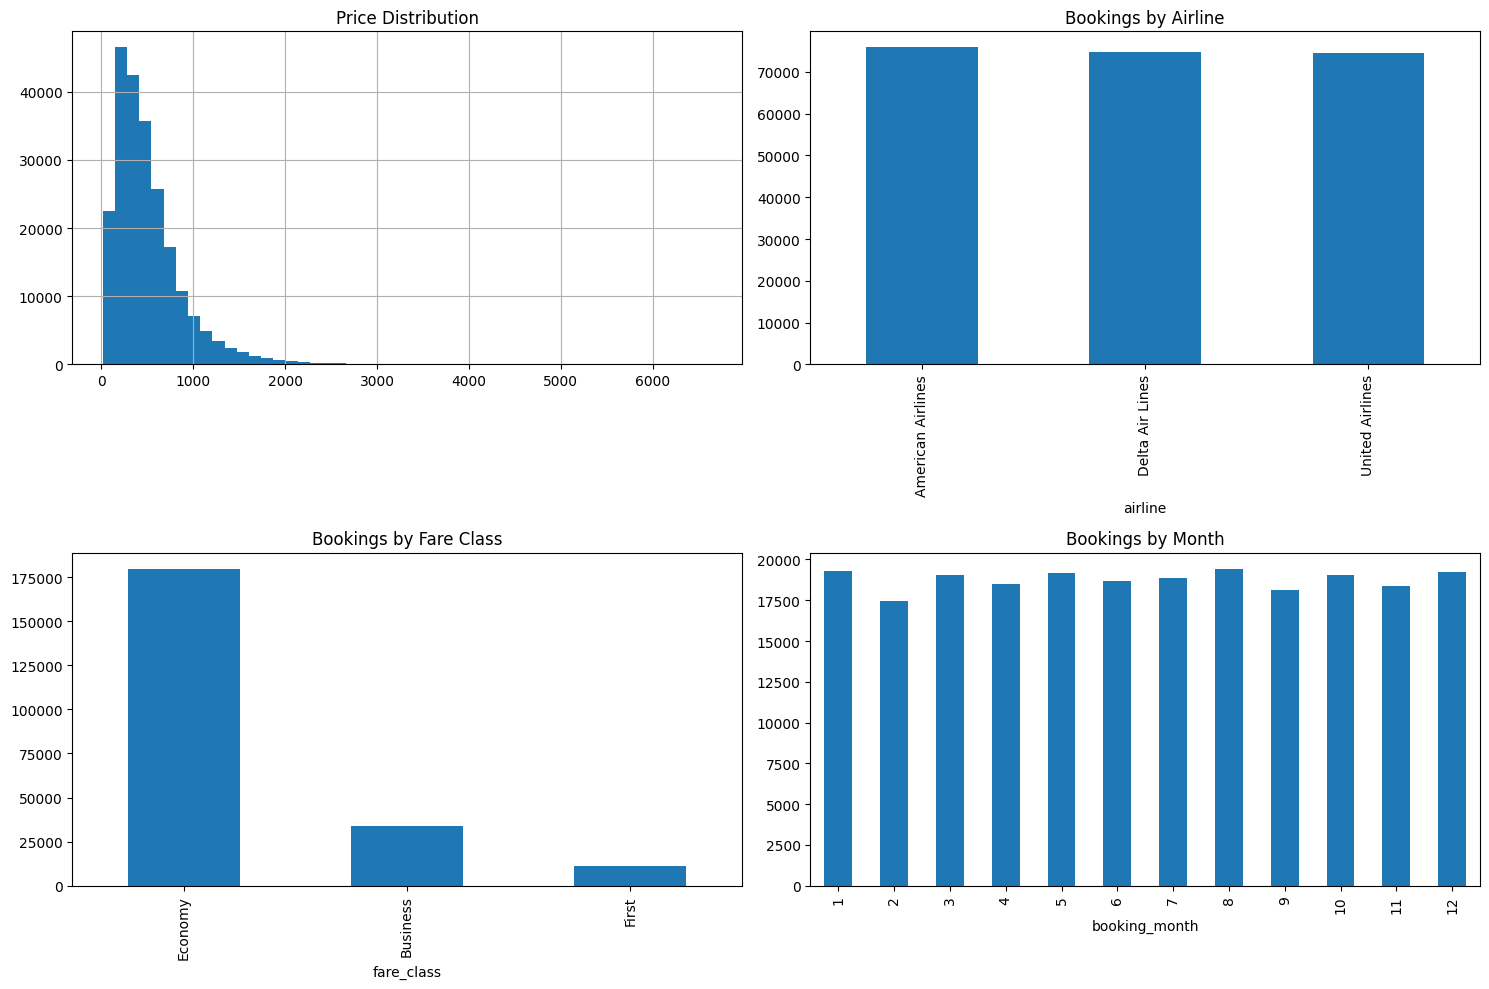

In [ ]:
# plt.figure(figsize=(12, 6))
# plt.hist(df_booking['price'], bins=50)
# plt.title('Distribution of Flight Prices')
# plt.xlabel('Price')
# plt.ylabel('Frequency')
# plt.show()

# Convert datetime columns
df_booking['booking_dt'] = pd.to_datetime(df_booking['booking_dt'])
df_booking['departure_dt'] = pd.to_datetime(df_booking['departure_dt'])

# Plotting distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price distribution
df_booking['price'].hist(bins=50, ax=axes[0,0])
axes[0,0].set_title('Price Distribution')

# Bookings by airline
df_booking['airline'].value_counts().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Bookings by Airline')

# Bookings by fare class
df_booking['fare_class'].value_counts().plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Bookings by Fare Class')

# Bookings by month
df_booking['booking_month'] = df_booking['booking_dt'].dt.month
df_booking['booking_month'].value_counts().sort_index().plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Bookings by Month')

plt.tight_layout()
plt.show()


## Target Analysis

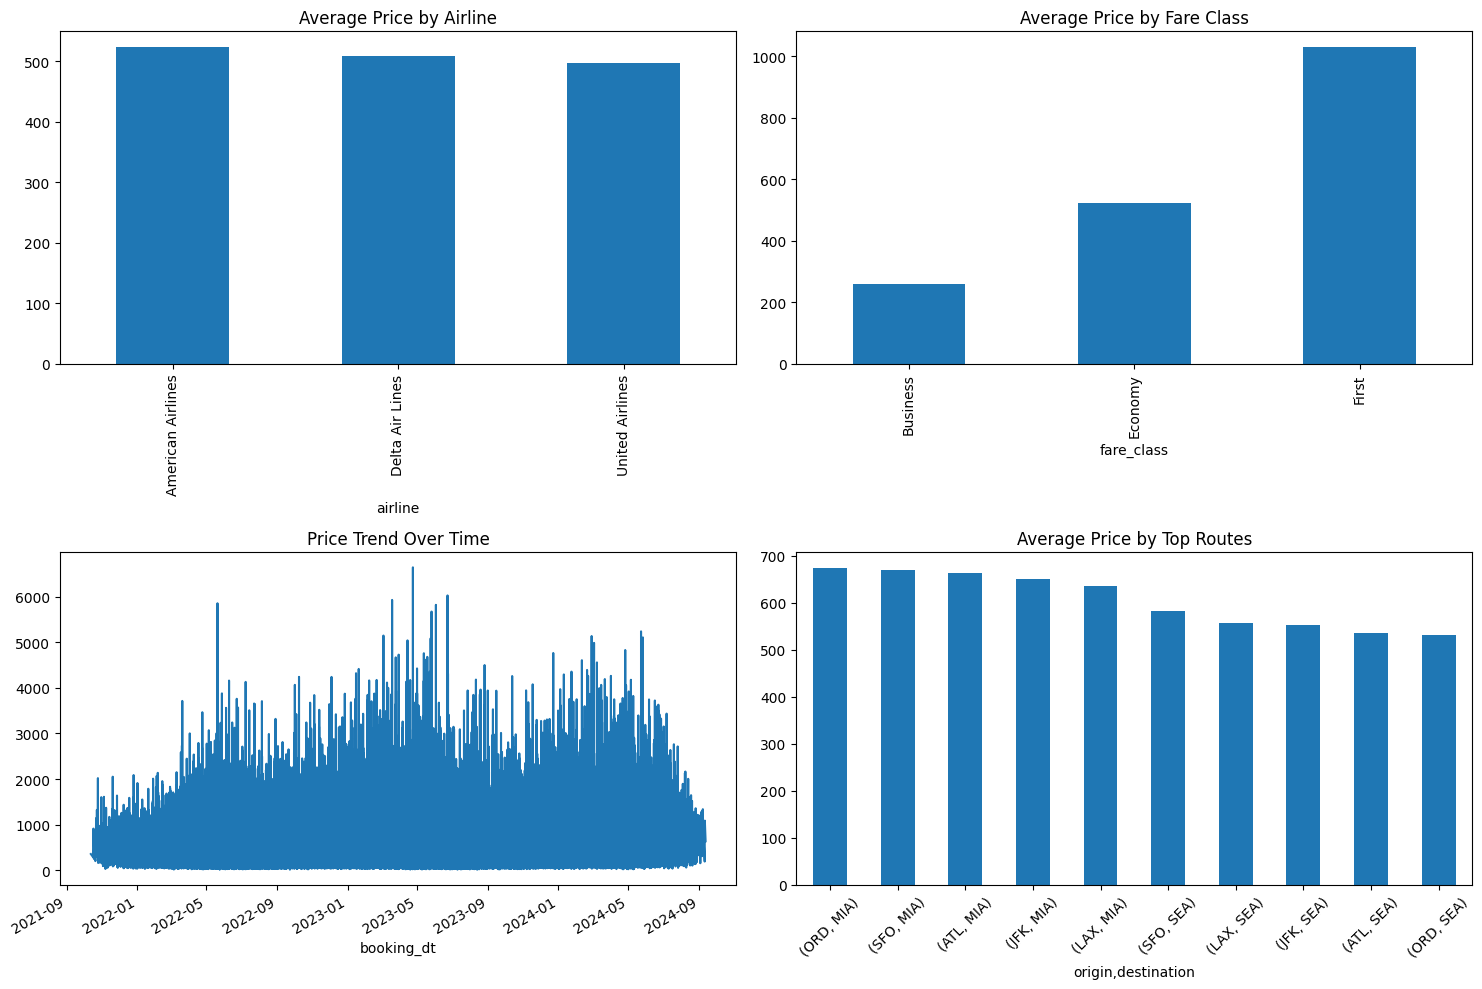

In [ ]:
df_booking['booking_dt'] = pd.to_datetime(df_booking['booking_dt'])
df_booking['departure_dt'] = pd.to_datetime(df_booking['departure_dt'])

# avg_price_by_airline = df_booking.groupby('airline')['price'].mean().sort_values(ascending=False)
# plt.figure(figsize=(10, 6))
# avg_price_by_airline.plot(kind='bar')
# plt.title('Average Price by Airline')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# Price analysis by different factors
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Average price by airline
df_booking.groupby('airline')['price'].mean().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Average Price by Airline')

# Average price by fare class
df_booking.groupby('fare_class')['price'].mean().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Average Price by Fare Class')

# Price trend over time
df_booking.groupby('booking_dt')['price'].mean().plot(ax=axes[1,0])
axes[1,0].set_title('Price Trend Over Time')

# Price by route
top_routes = df_booking.groupby(['origin', 'destination'])['price'].mean().nlargest(10)
top_routes.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Average Price by Top Routes')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 🛢️ Step 3 - Data Preparation

✍️ Data preparation transforms raw data into a suitable format for machine learning models, enhancing their accuracy and efficiency. Your task is to clean, transform, and organize the airfare data. Here are suggestions:

*   Format Fields: Ensure data types are appropriate for analysis (e.g., datetime, categorical).
*   Split Data: Divide the dataset into training, validation, and testing sets to evaluate model performance robustly. Consider chronological order for time-series data.

💡 You are not restricted to these steps. If you identify additional steps to enhance the data, feel free to include them!

## Format Fields

In [ ]:
df_model = df_booking.copy()

# Create label encoders for categorical variables
le_dict = {}
categorical_cols = ['airline', 'origin', 'destination', 'fare_class']
for col in categorical_cols:
    le_dict[col] = LabelEncoder()
    df_model[col] = le_dict[col].fit_transform(df_model[col])

## Split Data

In [ ]:
train_cutoff = df_model['booking_dt'].max() - timedelta(days=30)
df_train = df_model[df_model['booking_dt'] <= train_cutoff]
df_test = df_model[df_model['booking_dt'] > train_cutoff]

# 🚀 Step 4 - Feature Engineering

✍️ Feature engineering boosts model performance! It's about creating new features from existing ones to help the model better understand the data and improve predictions.

Here are suggestions to help you create new features:

1. **Compute Delta**: Calculate the time difference between booking and departure dates, as it's likely a key factor in pricing.
2. **Decompose Timestamps**: Extract valuable information from booking and departure dates, like year, month, day of the week, etc.

💡 If you think of any other features that could be insightful, go ahead and experiment. Feature engineering is all about finding what works best for your model!

In [ ]:
def engineer_features(df):
    # Compute booking window (days between booking and departure)
    df['booking_window'] = (df['departure_dt'] - df['booking_dt']).dt.total_seconds() / (24 * 3600)

    # Extract temporal features from booking date
    df['booking_month'] = df['booking_dt'].dt.month
    df['booking_day'] = df['booking_dt'].dt.day
    df['booking_weekday'] = df['booking_dt'].dt.weekday

    # Extract temporal features from departure date
    df['departure_month'] = df['departure_dt'].dt.month
    df['departure_day'] = df['departure_dt'].dt.day
    df['departure_weekday'] = df['departure_dt'].dt.weekday

    return df

df_train = engineer_features(df_train)
df_test = engineer_features(df_test)

# 📍 Step 5 - Feature Selection

✍️ Feature selection prevents model overfitting and improves training speed. Find the most relevant features for model prediction. You can consider a method such as the Random Forest Feature Importance.

In [ ]:
feature_cols = ['airline', 'origin', 'destination', 'booking_window',
                'booking_month', 'booking_day', 'booking_weekday',
                'departure_month', 'departure_day', 'departure_weekday',
                'fare_class']

X_train = df_train[feature_cols]
y_train = df_train['price']
X_test = df_test[feature_cols]
y_test = df_test['price']

# 🤖 Step 6 - Model Selection

✍️ Model selection is where we pick the champion algorithm that will power our predictions. It's about carefully evaluating different models and choosing the one that best suits our dataset and prediction task.

Your task is to experiment with different model architectures, train them, and assess their performance.

Here are suggestions on how to start this process:

1. Baseline Model: Start by establishing a baseline performance benchmark with a simple yet effective model like XGBoost. This sets a foundation to compare against when exploring more complex approaches.

2. Hyperparameter Tuning: Fine-tune the parameters of your chosen model using techniques like grid search or random search to unlock its full potential and achieve optimal performance.

💡 Consider using the XGBoost model, or any other models (e.g., linear regression, random forest).

In [ ]:
# Train XGBoost model
model = xgb.XGBRegressor(random_state=SEED)
model.fit(X_train, y_train)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:\n", feature_importance)


Feature Importance:
               feature  importance
10         fare_class    0.449649
3      booking_window    0.197552
2         destination    0.123196
7     departure_month    0.069814
6     booking_weekday    0.047133
9   departure_weekday    0.030483
4       booking_month    0.028398
0             airline    0.016579
1              origin    0.013512
8       departure_day    0.012622
5         booking_day    0.011062


# 📊 Step 7 - Evaluation

✍️ Model evaluation is where we put our model to the test and determine its true performance. It's about rigorously assessing how well our chosen model generalizes to unseen data and identifying any areas for improvement. Your task is to evaluate your model using a variety of metrics and techniques, focusing on:

Consider evaluating your model with the following points:

1. **Benchmark Comparison:** Compare your model's performance against a simple business method. This helps provide context and demonstrate the model's advantages over a simpler approach.

2. **Simpson's Paradox:** Note that model performance may vary when you assess the subgroups. Do you see that the ML approach is consistently better across subgroups such as airfare_class?

💡 Remember, model evaluation is more than just looking at a single metric. Consider using multiple metrics (e.g., MAPE, RMSE, R-squared) to get a comprehensive view of your model's performance.

In [ ]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"\n{model_name} MAPE: {mape:.4f}")
    return mape

# Evaluate on test set
y_pred_test = model.predict(X_test)
test_mape = evaluate_model(y_test, y_pred_test, "XGBoost")


XGBoost MAPE: 0.6170


# ✈️ Step 8 - Airfare Scenario Planning

✍️ This is the main aim for the ML approach. We want to build a tool that uses ML to help useres make informed booking decisions.

Given the following inputs:

1. Current Date
2. Departure Date
3. Airline
4. Origin
5. Destination
6. Fare Class

Predict the future airfare prices across a range of potential booking dates. Present these predictions in a clear and understandable format. Consider using a chart.

💡 Consider providing an actionable insight that helps users identify the optimal booking date within a specified timeframe (e.g., next 7 days) to potentiallly maximize savings.

In [ ]:
# Choose flight

#@title Example Form
today_date = '2024-11-20' #@param {type:"string"}
departure_date = '2024-12-08' #@param {type:"string"}
airline = 'American Airlines' #@param ['American Airlines', 'Delta Air Lines', 'United Airlines']
origin = 'JFK' #@param ['JFK', 'LAX', 'ORD', 'SFO', 'ATL']
destination = 'DEN' #@param ['BOS', 'DFW', 'MIA', 'SEA', 'DEN']
fare_class = 'Business' #@param ["Economy", "Business", "First"]

# Check that the departure date is greater than the today date
if departure_date <= today_date:
    raise ValueError("Departure date must be greater than today's date.")

Available airports: ['ORD' 'SFO' 'ATL' 'JFK' 'LAX']
Available destinations: ['BOS' 'DFW' 'MIA' 'SEA' 'DEN']


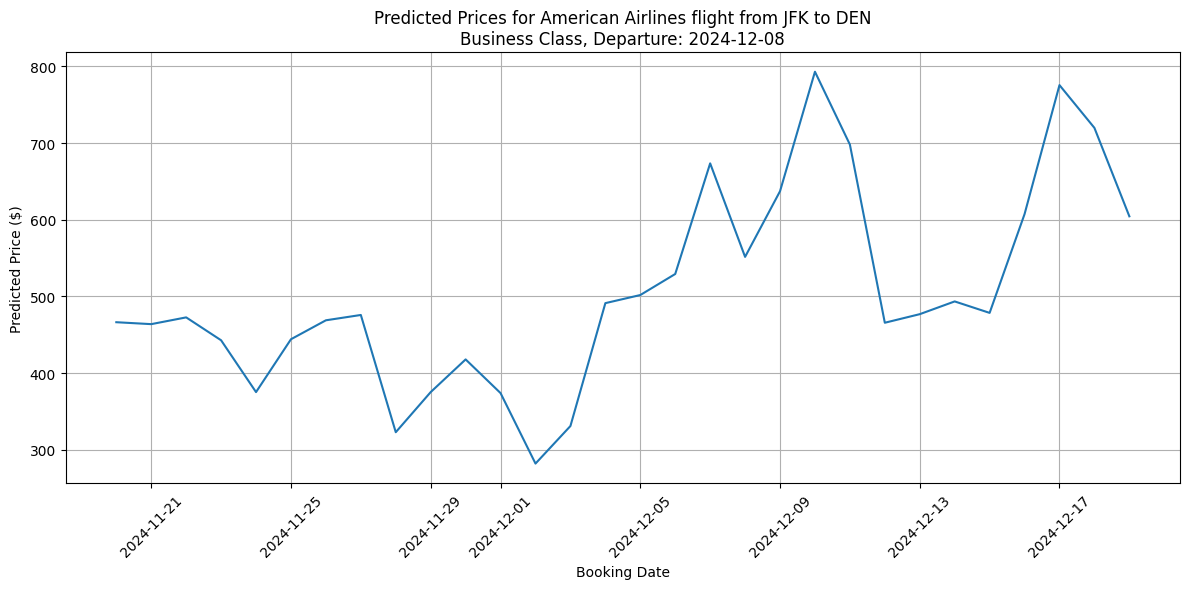


Recommended booking date: 2024-12-02
Predicted best price: $282.18


In [ ]:
# Print available options from training data
print("Available airports:", df_booking['origin'].unique())
print("Available destinations:", df_booking['destination'].unique())

def predict_future_prices(today_date, departure_date, airline, origin, destination,
                         fare_class, model, le_dict, num_days=30):

    # Validate inputs exist in training data
    if origin not in le_dict['origin'].classes_:
        raise ValueError(f"Origin airport '{origin}' not found in training data. Available options: {le_dict['origin'].classes_}")
    if destination not in le_dict['destination'].classes_:
        raise ValueError(f"Destination airport '{destination}' not found in training data. Available options: {le_dict['destination'].classes_}")
    if airline not in le_dict['airline'].classes_:
        raise ValueError(f"Airline '{airline}' not found in training data. Available options: {le_dict['airline'].classes_}")
    if fare_class not in le_dict['fare_class'].classes_:
        raise ValueError(f"Fare class '{fare_class}' not found in training data. Available options: {le_dict['fare_class'].classes_}")

    # Convert dates to datetime
    today_dt = pd.to_datetime(today_date)
    departure_dt = pd.to_datetime(departure_date)

    # Create prediction dates
    dates = [today_dt + timedelta(days=i) for i in range(num_days)]

    # Create features for each date
    predictions = []
    for booking_dt in dates:
        features = pd.DataFrame({
            'airline': [le_dict['airline'].transform([airline])[0]],
            'origin': [le_dict['origin'].transform([origin])[0]],
            'destination': [le_dict['destination'].transform([destination])[0]],
            'fare_class': [le_dict['fare_class'].transform([fare_class])[0]],
            'booking_window': [(departure_dt - booking_dt).total_seconds() / (24 * 3600)],
            'booking_month': [booking_dt.month],
            'booking_day': [booking_dt.day],
            'booking_weekday': [booking_dt.weekday()],
            'departure_month': [departure_dt.month],
            'departure_day': [departure_dt.day],
            'departure_weekday': [departure_dt.weekday()]
        })

        pred_price = model.predict(features[feature_cols])[0]
        predictions.append({
            'booking_date': booking_dt,
            'predicted_price': pred_price
        })

    return pd.DataFrame(predictions)

# Generate predictions
predictions_df = predict_future_prices(
    today_date, departure_date, airline, origin, destination, fare_class,
    model, le_dict
)

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(predictions_df['booking_date'], predictions_df['predicted_price'])
plt.title(f'Predicted Prices for {airline} flight from {origin} to {destination}\n{fare_class} Class, Departure: {departure_date}')
plt.xlabel('Booking Date')
plt.ylabel('Predicted Price ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Find optimal booking date
best_price = predictions_df['predicted_price'].min()
best_date = predictions_df.loc[predictions_df['predicted_price'].idxmin(), 'booking_date']

print(f"\nRecommended booking date: {best_date.strftime('%Y-%m-%d')}")
print(f"Predicted best price: ${best_price:.2f}")